In [1]:
import os
import numpy as np
import pandas as pd
import string
from nltk.corpus import stopwords
import re
import os
from collections import Counter
import json

import ekphrasis
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import gc
import emoji
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertModel, AutoTokenizer, MPNetModel, RobertaModel, BloomModel, OPTModel, AutoModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import recall_score
from utils import *

/home/mayukh/miniconda3/envs/contrastive_decoding/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def print_report(y_pred, y):
    print(classification_report(y, y_pred, digits=3))

<h6>Loading the dataset</h6>

In [4]:
text_processor = get_text_preprocessor()

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [5]:
text_train, train_labels = get_data("data/tweet_goEmotions_train.csv")
text_val, val_labels = get_data("data/tweet_goEmotions_val.csv")
text_test, test_labels = get_data("data/tweet_goEmotions_test.csv")

In [6]:
print(len(text_train))
print(len(text_val))
print(len(text_test))

36308
4548
4590


<h6>Text pre-processing</h6>

In [7]:
text_train = pre_process_text(text_train, 'slang.txt', text_processor)
print("******************************** Train set Completed ***************************************")
text_val = pre_process_text(text_val, 'slang.txt', text_processor)
print("******************************** Val set Completed ***************************************")
text_test = pre_process_text(text_test, 'slang.txt', text_processor)
print("******************************** Test set Completed ***************************************")

******************************** Train set Completed ***************************************
******************************** Val set Completed ***************************************
******************************** Test set Completed ***************************************


<h8>Longest tokens analysis</h8>

In [8]:
u = lambda text: len(text.split(" "))
sentence_lengths = []
for x in text_train:
    sentence_lengths.append(u(x))
print(sorted(sentence_lengths)[-100:])
print(max(sentence_lengths))

[40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48, 49, 49, 50, 50, 50, 52, 52, 53, 53, 53, 53, 55, 56, 57, 58, 65, 66, 70, 74, 88, 90, 283, 485]
485


<h6>Text pre-processing completed</h6>

In [9]:
config = {
    'model': AutoModel.from_pretrained("microsoft/deberta-large"),
    'model_type': "microsoft/deberta-large",
    'embed_dim': 1024,
    'label_size': 28
}

In [10]:
class datasetLoader(Dataset):

    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]
        label = self.labels[idx]
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": torch.tensor(label)}

In [11]:
tokenizer = AutoTokenizer.from_pretrained(config['model_type'])

In [12]:
# max_length: goEmotions - 40
# max_length: empathetic - 40
# max_length: tweetEmotion - 50
# max_length: tweetHate - 70

train_encodings = tokenizer(list(text_train), max_length=40, truncation=True, padding='longest', return_tensors='pt')
val_encodings = tokenizer(list(text_val), max_length=40, truncation=True, padding='longest', return_tensors='pt')
test_encodings = tokenizer(list(text_test), max_length=40, truncation=True, padding='longest', return_tensors='pt')

In [13]:
train_dataset = datasetLoader(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = datasetLoader(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
test_dataset = datasetLoader(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [15]:
# Checking the datatype
for dl in train_dataloader:
    print((dl['input_ids'].dtype))
    print((dl['attention_mask'].dtype))
    break

torch.int64
torch.int64


In [16]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda:4"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda:4 device


<h9>Defining the main model class</h9>

In [17]:
class exit_classification_head(nn.Module):
    def __init__(self, embed_dim, label_size):
        super(exit_classification_head, self).__init__()
        self.embed_dim = embed_dim
        self.label_size = label_size

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(self.embed_dim, 128),
            nn.ReLU(),
            nn.Linear(128, self.label_size)
        )

    def forward(self, feature_logits):
        logits = self.linear_relu_stack(feature_logits)
        return logits

In [18]:
# del model
# del confif
# del optimizer
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [19]:
class contrastiveNetwork(nn.Module):
    def __init__(self, config):
        super(contrastiveNetwork, self).__init__()

        self.embed_dim = config['embed_dim']
        self.label_size = config['label_size']

        self.model = config['model']
        self.classification_head = exit_classification_head(self.embed_dim, self.label_size)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, input_ids, attention_mask):
        pooler = self.model(input_ids, attention_mask).last_hidden_state[:,0,:]
        logits = self.classification_head(pooler)
        probs = self.softmax(logits)
        return logits, probs


model = contrastiveNetwork(config)
model.to(device)
print(model)

contrastiveNetwork(
  (model): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=1024, out_features=3072, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=1024, out_features=1024, bias=False)
              (pos_q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (intermed

In [20]:
loss_fn = nn.CrossEntropyLoss()

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=4e-6)

In [22]:
def train(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)
    model.train()
    
    loop = tqdm(enumerate(dataloader), leave=False, total=len(dataloader))

    for batch, dl in loop:
        input_ids = dl['input_ids'].to(device)
        attention_mask = dl['attention_mask'].to(device)
        y = dl['labels'].to(device)

        # Compute prediction error
        pred, probs = model(input_ids, attention_mask)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(y)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [23]:
# This function sets the forward hooks which store the output logits.
# Only ([CLS]/<s> token logits are stored for classification). For decoding index of current step can be passed.
def getlogits(name):
    def hook(model, input, output):
        output = output.detach()
        logits[name] = output[:,0,:]
    return hook

# Initialising the hooks on the output layers of each attention block
def initialise_hooks(model):
    hooks = {}
    blocks = len(model.model.encoder.layer)
    for i in range(0, blocks):
        hooks[i] = model.model.encoder.layer[i].output.register_forward_hook(getlogits('block_' + str(i)))
    return hooks

# Removing the hooks once eval is done -- cleanup step
def detach_hooks(hooks, model):
    blocks = len(model.model.encoder.layer)
    for i in range(0, blocks):
        hooks[i].remove()

# Get the softmax probabilities for the outputs from each block ([CLS]/<s> token)
def get_early_logits(early_probs, model, attention_mask):
    for i in range(len(early_probs)):
        early_logits = logits['block_' + str(i)]
        early_logits = model.classification_head(early_logits)
        probs = model.softmax(early_logits)
#         probs = early_logits
        early_probs['block_' + str(i)].append(probs.cpu())
    return early_probs

In [24]:
def evaluation(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss = 0
    Y_pred = []
    Y_true = []

    # Setting up early exiting parameters.
    global logits
    logits = {}
    early_probs = {}
    hooks = initialise_hooks(model)
    for i in range(0, len(model.model.encoder.layer)):
        early_probs['block_' + str(i)] = []

    # Early exit parameter setup finished
    loop = tqdm(enumerate(dataloader), leave=False, total=len(dataloader))

    with torch.no_grad():
        for batch, dl in loop:
            input_masks = dl['input_ids'].to(device)
            attention_mask = dl['attention_mask'].to(device)
            y = dl['labels'].to(device)
            pred, probs = model(input_masks, attention_mask)
            Y_pred.append(pred.argmax(1).cpu())
            Y_true.append(y.cpu())
            early_probs = get_early_logits(early_probs, model, attention_mask)
    
    detach_hooks(hooks, model)
    # Checking logits output

    for i in range(len(early_probs)):
        early_probs['block_' + str(i)] = torch.cat(early_probs['block_' + str(i)])

    # Whole dataset validation loop
    Y_pred = torch.cat(Y_pred)
    Y_true = torch.cat(Y_true)
    print_report(Y_pred, Y_true)
    return early_probs

In [25]:
# epochs = 3
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train(train_dataloader, model, loss_fn, optimizer)
# print("Done!")

In [27]:
# torch.save(model.state_dict(), 'goEmotions_deberta.pth')
# model.load_state_dict(torch.load('goEmotions_deberta.pth'))

In [28]:
# Dictionary of early exiting probabilities. 
# Stores woth keys block_n where n is the layer number.

early_probs = evaluation(test_dataloader, model, loss_fn)

              precision    recall  f1-score   support

           0      0.701     0.672     0.686       348
           1      0.795     0.855     0.824       186
           2      0.470     0.595     0.525       131
           3      0.436     0.263     0.328       194
           4      0.573     0.301     0.394       236
           5      0.418     0.442     0.429        86
           6      0.471     0.423     0.446        97
           7      0.498     0.597     0.543       176
           8      0.638     0.536     0.583        56
           9      0.509     0.330     0.400        88
          10      0.482     0.415     0.446       195
          11      0.543     0.579     0.561        76
          12      0.579     0.478     0.524        23
          13      0.458     0.386     0.419        57
          14      0.676     0.769     0.719        65
          15      0.958     0.881     0.918       260
          16      0.000     0.000     0.000         2
          17      0.610    

/home/mayukh/miniconda3/envs/contrastive_decoding/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mayukh/miniconda3/envs/contrastive_decoding/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mayukh/miniconda3/envs/contrastive_decoding/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [29]:
# Can be used to print the result from early exiting layers.
# print_report(early_probs['block_23'].argmax(1), test_labels)

<h6>Amateur Layer Selection</h6>

In [30]:
# Dynamic amateur layer selection.
# This function dynamically selects the 
# n_blocks defines the upper limit of layers not included for amateur layer selection.

n_blocks = 15
def get_max_diff(early_probs):
    final_layer_probs = early_probs['block_23']
    js_data = []
    not_blocks = ["block_" + str(i) for i in range(0,n_blocks)]
    for block, probs in early_probs.items():
        if(block in not_blocks):
            js_data.append(np.zeros(len(probs)))
            continue
        js_data.append((1-np.array(torch.nn.functional.cosine_similarity(final_layer_probs, probs, dim=1))/2)) 
    return js_data

In [31]:
js = np.array(get_max_diff(early_probs))
js = np.argmax(js.T, axis=1)

In [32]:
Counter(js)

Counter({15: 3579, 19: 738, 16: 155, 17: 70, 18: 29, 20: 17, 21: 2})

In [33]:
dynamic_amateur = []
i = 0
for j in js:
    t = 'block_'+str(j)
    dynamic_amateur.append(early_probs[t][i].numpy())
    i+=1
dynamic_amateur = np.array(dynamic_amateur)

In [34]:
np.shape(dynamic_amateur)

(4590, 28)

<h5>Applying contrastive decoding</h5>

In [36]:
probs_base = dynamic_amateur
probs_large = early_probs['block_23'].numpy()

In [37]:
print(np.shape(probs_base))
print(np.shape(probs_large))

(4590, 28)
(4590, 28)


In [38]:
# Main class for CD.
# The set_hyper_params function is used to set dynamic contrastive strength based on a bool paramter 'dynamic'.
# beta is used for extrapolation layer is dynamic is 'True' else it represents the contrastive strength.

class contrastive_decoding():
    def __init__(self, p_exp_distribution, p_ama_distribution, jsd):
        self.alpha = 1.0
        self.beta = None
        
        self.p_exp = p_exp_distribution
        self.p_ama = p_ama_distribution
        self.jsd = jsd
        
    def initialise_beta(self, beta):
        l_3 = np.ones(len(self.jsd))*beta
        l_2 = np.ones(len(self.jsd))*23.0
        l_1 = self.jsd
        beta_d = (l_3-l_2)/(l_2-l_1)
        beta_d = np.expand_dims(beta_d, axis=1)
        return beta_d

    def set_hyper_params(self, alpha, beta, dynamic=False):
        # Seperate setter function as it makes it easy to evaluate CD for different hyperparameters with a single object.
        self.alpha = alpha
        if not dynamic:
            self.beta = beta
        else:
            self.beta = self.initialise_beta(beta)

    def get_plausibility_constraint(self, p_exp):
        p_exp_max = np.max(p_exp, axis=1)
        p_exp_max = np.expand_dims(p_exp_max, axis=1)
        plausibility_ratio = np.divide(p_exp, p_exp_max)
        plausibility_mask = (plausibility_ratio >= self.alpha).astype(dtype=int)
        return plausibility_mask

    def get_contrastive_pred(self):
        plausibility_mask = self.get_plausibility_constraint(self.p_exp)
        cd_score = (1+self.beta)*np.log(self.p_exp) - (self.beta)*np.log(self.p_ama)
        cd_score = np.multiply(cd_score, plausibility_mask)
        cd_score[cd_score == 0] = -999999999
        return np.argmax(cd_score, axis=1)

    def get_contrastive_prob(self):
        plausibility_mask = self.get_plausibility_constraint(self.p_exp)
        cd_score = (1+self.beta)*np.log(self.p_exp) - (self.beta)*np.log(self.p_ama)
        return cd_score

    def evaluate_cd(self, y):
        pred_cd = self.get_contrastive_pred()
        return f1_score(y, pred_cd, average='macro')

    def evaluate_exp(self, y):
        pred_exp = np.argmax(self.p_exp, axis=-1)
        return f1_score(y, pred_exp, average='macro')

In [39]:
def plot(cd_, alpha, beta_, true_labels, dynamic = False):
    f1_exp = np.full(len(beta_), cd_.evaluate_exp(true_labels))
    f1_val_cd = np.zeros(len(beta_))

    for i, beta in enumerate(beta_):
        cd_.set_hyper_params(alpha, beta, dynamic)
        f1_val_cd[i] = cd_.evaluate_cd(true_labels)
        
    plt.title("alpha: " + str(alpha))
    plt.plot(beta_, f1_val_cd, marker='o', color='green')
    plt.plot(beta_, f1_exp, color='green', linestyle='dashed')
    plt.show()

In [40]:
cd_obj = contrastive_decoding(probs_large, probs_base, js)

In [41]:
cd_obj.set_hyper_params(1.0, 0.0)
print(cd_obj.evaluate_exp(test_labels))
print(cd_obj.evaluate_cd(test_labels))

0.533876070278486
0.533876070278486


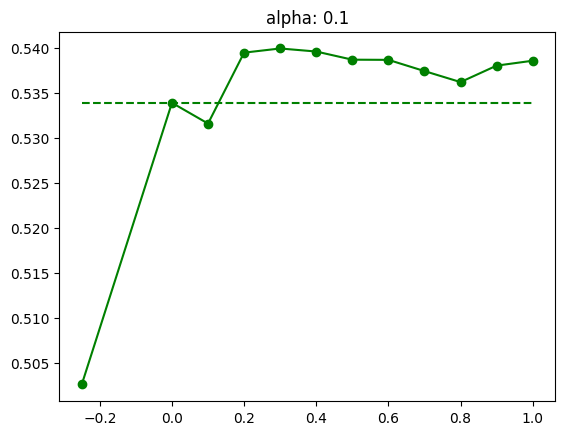

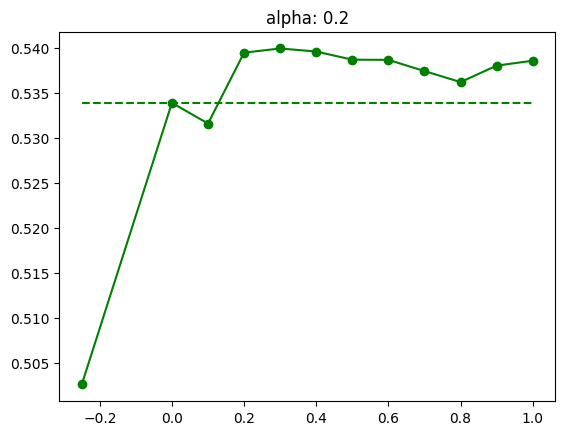

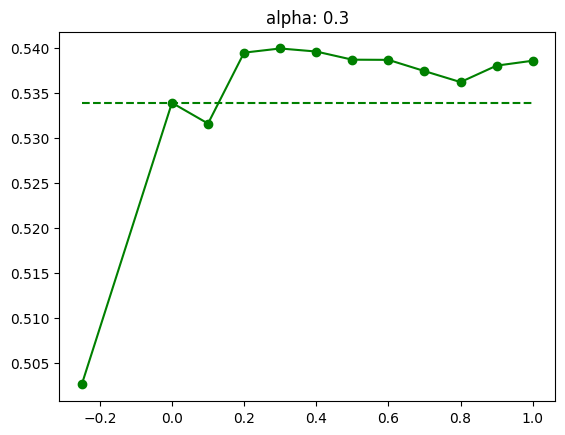

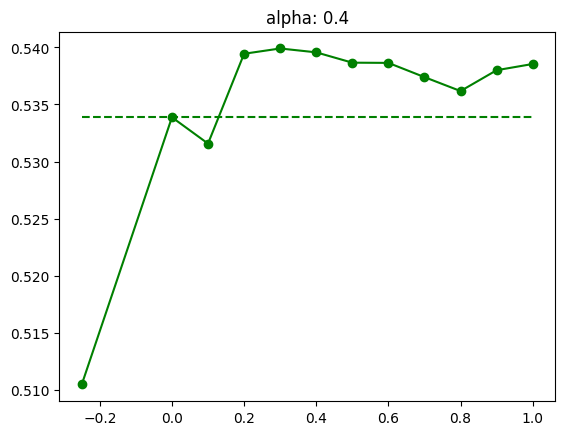

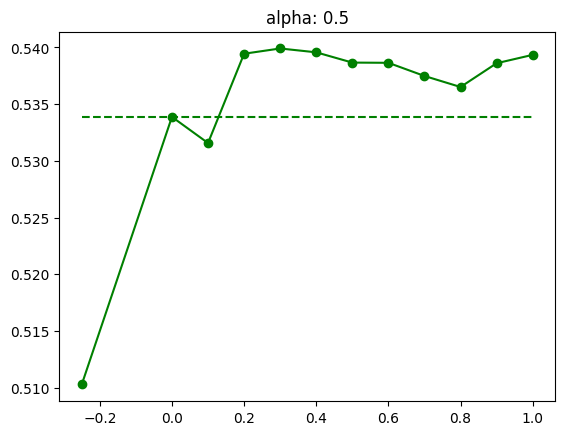

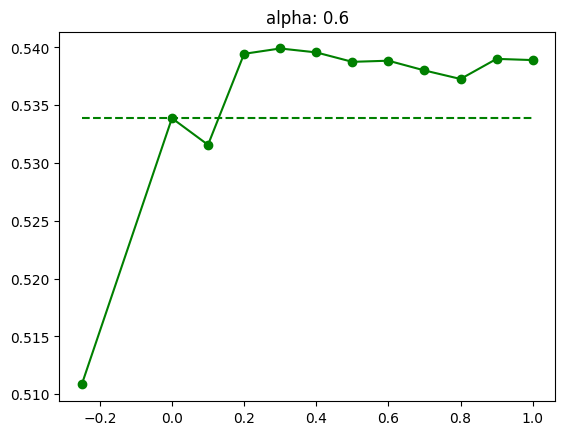

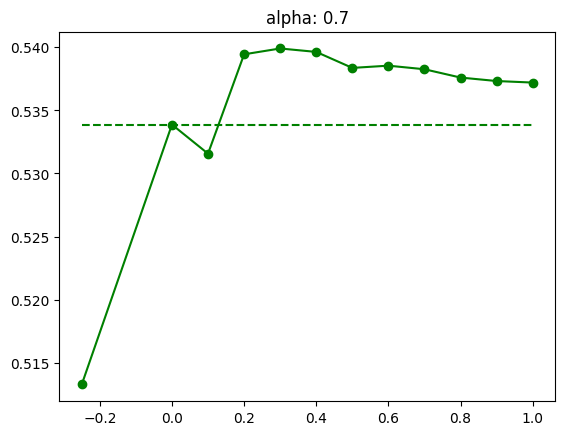

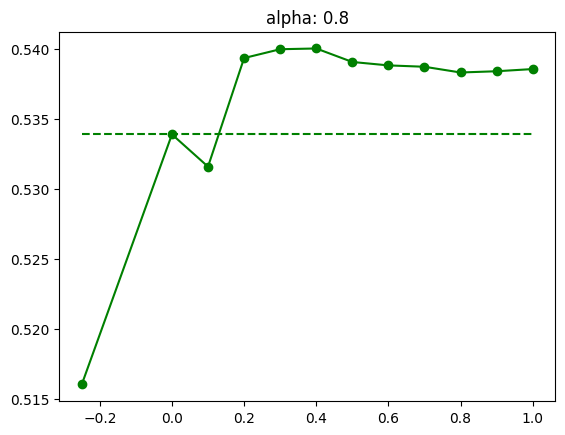

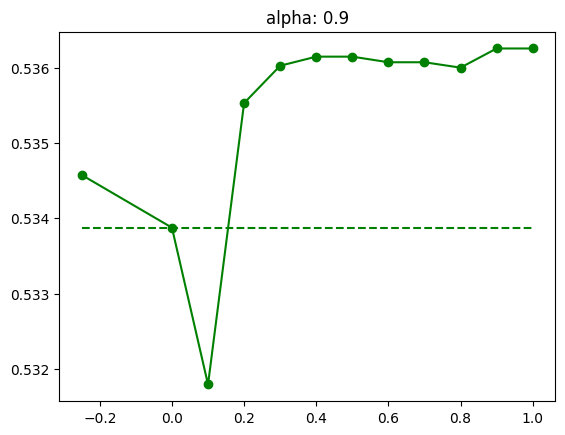

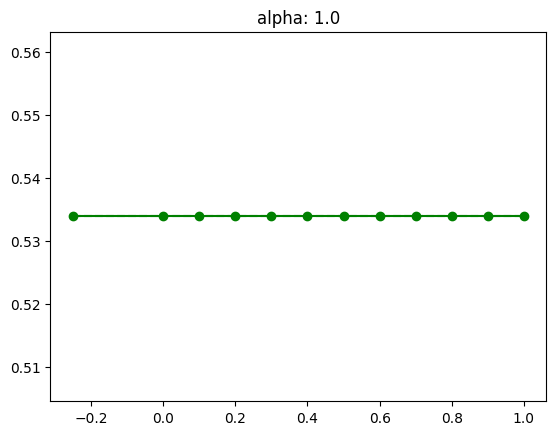

In [42]:
# Plots the CD results without dynamic contrastive strength
alpha_ = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
beta_ = np.array([-.25, 0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
for alpha in alpha_:
    plot(cd_obj, alpha, beta_, test_labels, False)

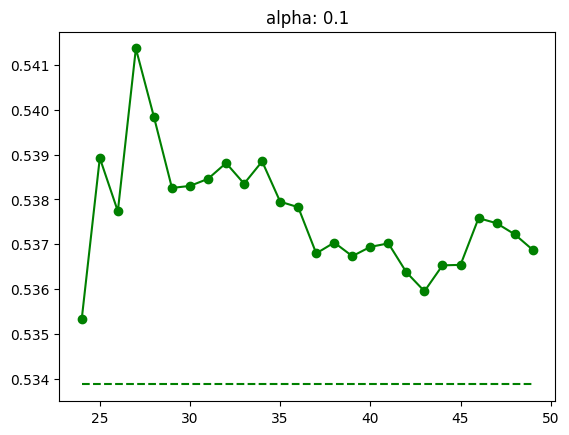

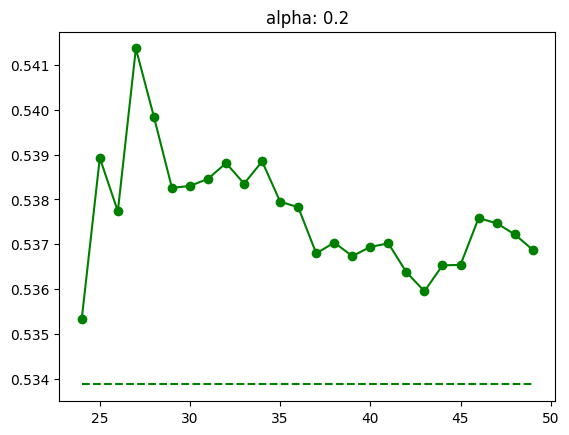

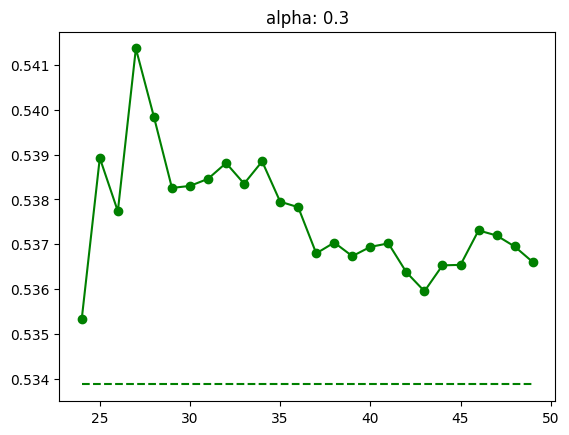

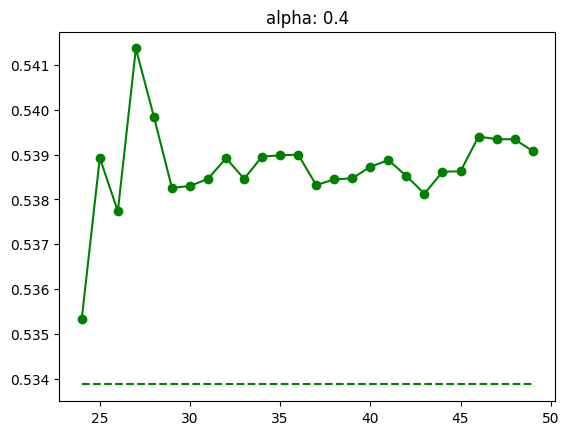

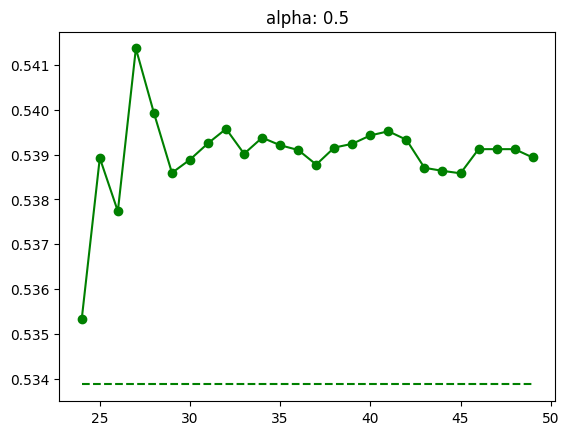

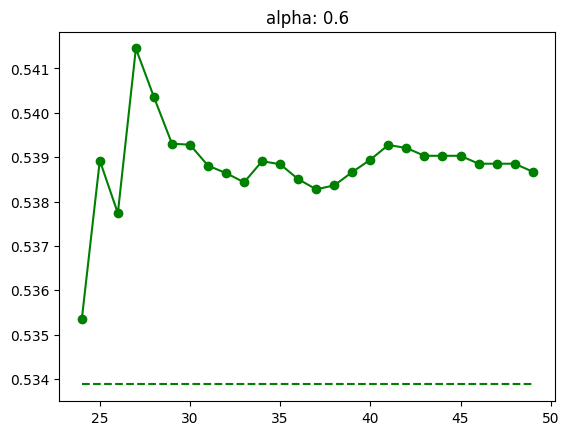

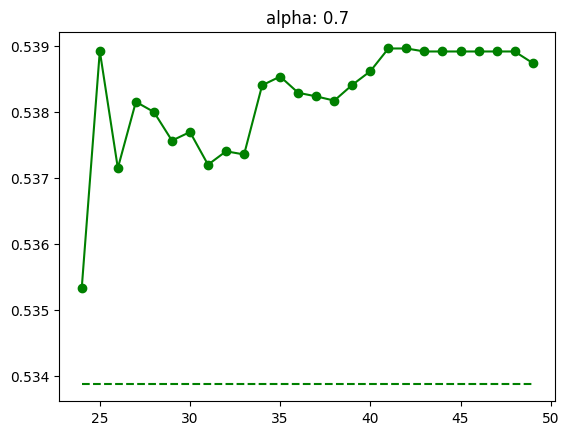

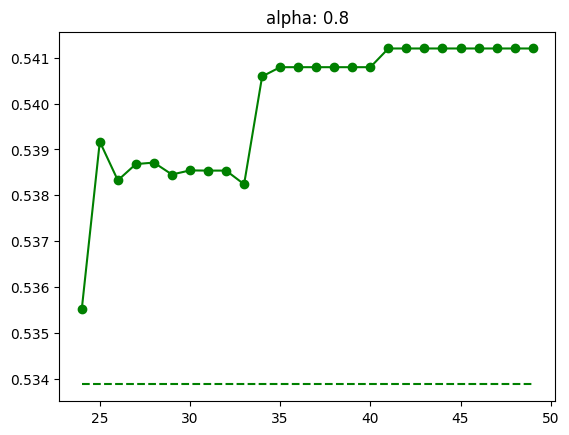

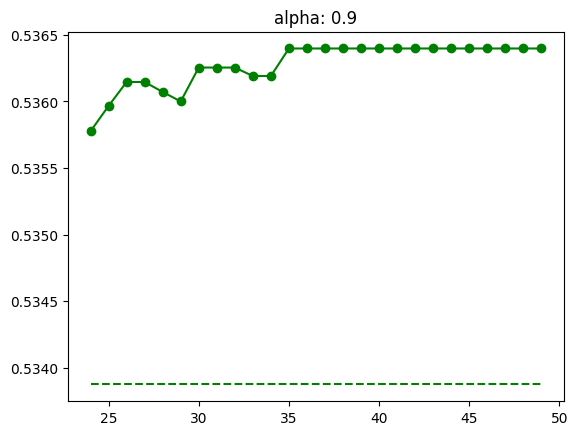

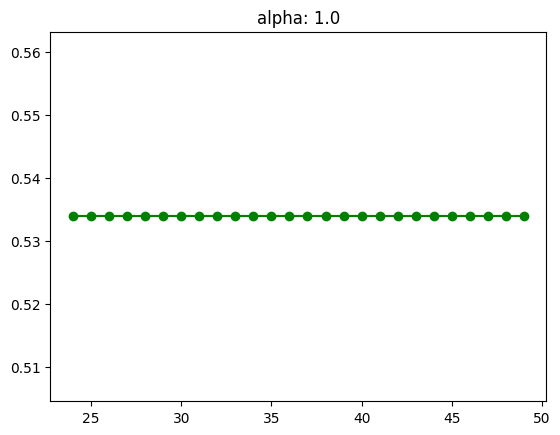

In [43]:
# Plots the CD results with dynamic contrastive strength. beta_ here contains the extrapolation layer
alpha_ = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
beta_ = np.arange(24,50)
for alpha in alpha_:
    plot(cd_obj, alpha, beta_, test_labels, True)